In [ ]:
#%%appyter init
from appyter import magic
magic.init(lambda _=globals: _())

In [ ]:
%%appyter markdown

<center> <h1> <img src="{{ url_for('static', filename='cluster-icon.svg') }}" style="height:45px;padding:0 10px 10px 0;display:inline"/> Patient Cohorts RNA-Seq Viewer</h1>
<h3>An appyter for the visualization and analysis of intra-cancer patient clusters based on RNA-Seq profiles and clinical data</h3></center>

---
By default, we use TCGA data. Users can optionally also upload their own datasets.

Each column in the RNA-Seq dataset corresponds to a row in the clinical dataset; both are referenced by the same identifier (here the `case_id` as provided by TCGA). 

The RNA-Seq data loaded from TCGA is in the form of raw counts mapped to genes with the HT-Seq Counts analysis package. We then filter for the most variable genes, normalize those counts, and reduce the dimensionality of the dataset further with PCA and UMAP.

To determine the ideal number of clusters, we probe a range and select the number based on a modified silhouette score that prioritizes more clusters (so we do not miss out on small clusters).

We identify the top genes for each cluster, using these for Enrichment analysis and treatment suggestion based on the drugs used for perurbation to produce signatures most opposite to each cluster in the L1000 dataset.

### Table of Contents:
1. [Import dataset](#import)
2. [Process data and compute clusters](#processing)
3. [Load Enrichr Data](#enrichr)
4. [Load L1000 Data](#l1000)

In [2]:
import os
import numpy as np
import pandas as pd
import requests
import time
from matplotlib import pyplot as plt
import seaborn as sns
from umap import UMAP
from scipy.stats import zscore
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn import metrics
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.cm as cm
from maayanlab_bioinformatics.dge import characteristic_direction
from maayanlab_bioinformatics.normalization import log2_normalize, filter_by_var, zscore_normalize
from maayanlab_bioinformatics.utils import merge
import plotly.express as px
import math
from collections import OrderedDict
import json
from jupyter_d3 import scatter_plot
from IPython.display import display, IFrame, Markdown, HTML
from textwrap import wrap

In [ ]:
%%appyter hide_code

{% do SectionField(
    name="DATASET",
    title="Dataset selection",
    subtitle='If using TCGA data, leave both file upload fields blank and simply select the desired cancer type.',
    img = "tcga-logo.png"
) %}


{% do SectionField(
    name='CONFIG',
    title='Analysis parameters',
    subtitle='Select various parameters for dimensionality reduction and dataset size. Defaults for n_neighbors and min_cluster_dist are based on the defaults used by the Seurat R Package for single cell genomics analysis.',
    img = "parameters-icon.svg"

) %}

{% do SectionField(
    name="ENRICHR_LIBS",
    title="Libraries to include in the Enrichr search",
    img = "enrichr-logo.png"
) %}

{% do SectionField(
    name="L1000FWD",
    title="L1000FWD search parameters",
    img = "l1000fwd.png"
) %}



In [ ]:
%%appyter code_eval

data_filename = '''{{ FileField(
    name='data_filename', 
    label='RNA-seq data file (.csv)', 
    description='Upload RNA-seq dataset in csv format. The index of the dataset are genes, the columns are samples.', 
    default='',
    section='DATASET'
) }}'''

clinical_data_filename = '''{{ FileField(
    name='clinical_data_filename', 
    label='Clinical data file (.csv)', 
    description='Upload clinical data in csv format. The first column should contain patient IDs corresponding to those in the RNA-seq file. Each subsequent column is a clinical data field.', 
    default='',
    section='DATASET'
) }}'''

cancer = '''{{ ChoiceField(
        name = "cancer",
        label = "Cancer type",
        description="The value provided as the primary diagnosis on cases in TCGA.",
        choices=["Infiltrating duct carcinoma, NOS","Squamous cell carcinoma, NOS","Lobular carcinoma, NOS","Acute myeloid leukemia, NOS","Hepatocellular carcinoma, NOS","Serous cystadenocarcinoma, NOS","Endometrioid adenocarcinoma, NOS","Adenocarcinoma, NOS","Clear cell adenocarcinoma, NOS","Glioblastoma","Mucinous adenocarcinoma","Transitional cell carcinoma","Malignant melanoma, NOS","Papillary adenocarcinoma, NOS"],
        section="DATASET",
        default="Serous cystadenocarcinoma, NOS" 
) }}'''
    
n_pca_components = {{ IntField(
    name='n_pca_components',
    label='Number of PCA components to use for UMAP',
    default=10,
    min=0,
    max=100,
    section='CONFIG',
) }}

n_neighbors = {{ IntField(
    name='n_neighbors',
    label='Number of neighbors for each projected datapoint computed by UMAP',
    description='Smaller values preserve local manifold structure in the dataset as opposed to overall global structure',
    default=40,
    min=2,
    max=200,
    section='CONFIG',
) }}

min_cluster_dist = {{ FloatField(
    name='min_cluster_dist',
    label='Minimum distance between UMAP-projected points',
    description='How tightly packed points produced by dimensionality reduction with UMAP are permitted to be.',
    default=0.3,
    min=0.1,
    max=1,
    section='CONFIG',
) }}

top_n_genes = {{ IntField(
    name='top_n_genes',
    label='Number of top most variable genes to analyze',
    description="The number of top most variable genes to use for analysis",
    default=2500,
    min=100,
    max=19000,
    section='CONFIG',
) }}

max_clusters_calculation = {{ RadioField(
    name="max_clusters_calculation",
    label="Method for calculating the maximum possible number of clusters",
    description = "n is the sample size (number of cases)",
    choices = [
         {
            "label": '''
                <math xmlns="http://www.w3.org/1998/Math/MathML">
                  <mstyle displaystyle="true">
                    <mfrac>
                      <msqrt>
                        <mrow>
                          <mi>n</mi>
                        </mrow>
                      </msqrt>
                      <mn>2</mn>
                    </mfrac>
                  </mstyle>
                </math>
            ''', 
            "value":"root/2"
        },
        {
            "label": '''
            <math xmlns="http://www.w3.org/1998/Math/MathML">
                <mstyle displaystyle="true">
                <msqrt>
                  <mrow>
                    <mi>n</mi>
                  </mrow>
                </msqrt>
              </mstyle>
            </math>
            ''', 
            "value":"root"
        }
    ],
    default = "root/2",
    section = 'CONFIG'
)}}



use_weighted_silhouette_score = {{BoolField(
    name="use_weighted_silhouette_score",
    label="Use a weighted silhouette score to determine ideal number of clusters",
    description = "A weighted score is a weighted combination of the original score and the value of k, therefore encouraging more clusters.",
    default = True,
    section = 'CONFIG'
)}}

use_second_deriv_method = {{BoolField(
    name="use_second_deriv_method",
    label="Use the most concave down local maxima of the silhouette score to determine k",
    description = "This method uses the unweighted silhouette score regardless of the choice above. If no maxima are found, we resort to k as determined by the chosen silhouette score method. ",
    default = True,
    section = 'CONFIG'
)}}

top_n_genes_enrichment = {{ IntField(
    name='top_n_genes_enrichment',
    label='Number of top genes to use for enrichment analysis',
    description='The number of \'top\' genes to use for enrichment analysis',
    default=250,
    min=100,
    max=1000,
    section='CONFIG',
) }}

heatmap_top_n = {{ IntField(
    name='cluster_top_n',
    label='Number of up and down genes per cluster for heatmap visualizatiton',
    default=100,
    min=100,
    max=1000,
    section='CONFIG',
) }}

top_n_results = {{ IntField(
    name='top_n_results',
    label='Number of top enrichment results',
    default=5,
    min=1,
    max=100,
    section='CONFIG',
) }}

use_default_libraries = {{BoolField(
    name="use_default_libraries",
    label="Use default Enrichr libraries?",
    description = "The default libraries include:\nKEGG_2019_Human,\nKEGG_2019_Mouse,\nGO_Biological_Process_2018,\nMGI_Mammalian_Phenotype_Level_4_2019,\nGWAS_Catalog_2019,\nENCODE_TF_ChIP-seq_2015.",
    default = False,
    section = 'ENRICHR_LIBS'
)}}


transcription_libraries = {{MultiChoiceField(name='transcription_libraries', 
                                            label='Transcription',
                                            default=[], 
                                            section = 'ENRICHR_LIBS',
                                            choices=[
                                                'ARCHS4_TFs_Coexp',
                                                'ChEA_2016',
                                                'ENCODE_and_ChEA_Consensus_TFs_from_ChIP-X',
                                                'ENCODE_Histone_Modifications_2015',
                                                'ENCODE_TF_ChIP-seq_2015',
                                                'Epigenomics_Roadmap_HM_ChIP-seq',
                                                'Enrichr_Submissions_TF-Gene_Coocurrence',
                                                'Genome_Browser_PWMs',
                                                'lncHUB_lncRNA_Co-Expression',
                                                'miRTarBase_2017',
                                                'TargetScan_microRNA_2017',
                                                'TF-LOF_Expression_from_GEO',
                                                'TF_Perturbations_Followed_by_Expression',
                                                'Transcription_Factor_PPIs',
                                                'TRANSFAC_and_JASPAR_PWMs',
                                                'TRRUST_Transcription_Factors_2019',
                                            ])  }}

pathways_libraries = {{ MultiChoiceField(name='pathways_libraries', 
                                         label='Pathways', 
                                         default=[], 
                                         section='ENRICHR_LIBS',
                                         choices=[
                                                    'ARCHS4_Kinases_Coexp',
                                                    'BioCarta_2016',
                                                    'BioPlanet_2019',
                                                    'BioPlex_2017',
                                                    'CORUM',
                                                    'Elsevier_Pathway_Collection',
                                                    'HMS_LINCS_KinomeScan',
                                                    'HumanCyc_2016',
                                                    'huMAP',
                                                    'KEA_2015',
                                                    'KEGG_2019_Human',
                                                    'KEGG_2019_Mouse',
                                                    'Kinase_Perturbations_from_GEO_down',
                                                    'Kinase_Perturbations_from_GEO_up',
                                                    'L1000_Kinase_and_GPCR_Perturbations_down',
                                                    'L1000_Kinase_and_GPCR_Perturbations_up',
                                                    'NCI-Nature_2016',
                                                    'NURSA_Human_Endogenous_Complexome',
                                                    'Panther_2016',
                                                    'Phosphatase_Substrates_from_DEPOD',
                                                    'PPI_Hub_Proteins',
                                                    'Reactome_2016',
                                                    'SILAC_Phosphoproteomics',
                                                    'SubCell_BarCode',
                                                    'Virus-Host_PPI_P-HIPSTer_2020',
                                                    'WikiPathways_2019_Human',
                                                    'WikiPathways_2019_Mouse']) }}

ontologies_libraries = {{ MultiChoiceField(name='ontologies_libraries', 
                                           label='Ontologies', 
                                           default=[], 
                                           section = 'ENRICHR_LIBS',
                                           choices=[
                                                'GO_Biological_Process_2018',
                                                'GO_Cellular_Component_2018',
                                                'GO_Molecular_Function_2018',
                                                'Human_Phenotype_Ontology',
                                                'Jensen_COMPARTMENTS',
                                                'Jensen_DISEASES',
                                                'Jensen_TISSUES',
                                                'MGI_Mammalian_Phenotype_Level_4_2019'
                                           ])  }}
    
diseases_drugs_libraries = {{ MultiChoiceField(name='diseases_drugs_libraries', 
                                               label='Diseases/Drugs', 
                                               default=[], 
                                               section = 'ENRICHR_LIBS',
                                               choices=[    
                                                    'Achilles_fitness_decrease',
                                                    'Achilles_fitness_increase',
                                                    'ARCHS4_IDG_Coexp',
                                                    'ClinVar_2019',
                                                    'dbGaP',
                                                    'DepMap_WG_CRISPR_Screens_Broad_CellLines_2019',
                                                    'DepMap_WG_CRISPR_Screens_Sanger_CellLines_2019',
                                                    'DisGeNET',
                                                    'DrugMatrix',
                                                    'DSigDB',
                                                    'GeneSigDB',
                                                    'GWAS_Catalog_2019',
                                                    'LINCS_L1000_Chem_Pert_down',
                                                    'LINCS_L1000_Chem_Pert_up',
                                                    'LINCS_L1000_Ligand_Perturbations_down',
                                                    'LINCS_L1000_Ligand_Perturbations_up',
                                                    'MSigDB_Computational',
                                                    'MSigDB_Oncogenic_Signatures',
                                                    'Old_CMAP_down',
                                                    'Old_CMAP_up',
                                                    'OMIM_Disease',
                                                    'OMIM_Expanded',
                                                    'PheWeb_2019',
                                                    'Rare_Diseases_AutoRIF_ARCHS4_Predictions',
                                                    'Rare_Diseases_AutoRIF_Gene_Lists',
                                                    'Rare_Diseases_GeneRIF_ARCHS4_Predictions',
                                                    'Rare_Diseases_GeneRIF_Gene_Lists',
                                                    'UK_Biobank_GWAS_v1',
                                                    'Virus_Perturbations_from_GEO_down',
                                                    'Virus_Perturbations_from_GEO_up',
                                                    'VirusMINT']) }}
    
cell_types_libraries = {{ MultiChoiceField(name='cell_types_libraries', 
                                           label='Cell Types', 
                                           default=[], 
                                           section = 'ENRICHR_LIBS',
                                           choices=[        
                                                'Allen_Brain_Atlas_down',
                                                'Allen_Brain_Atlas_up',
                                                'ARCHS4_Cell-lines',
                                                'ARCHS4_Tissues',
                                                'Cancer_Cell_Line_Encyclopedia',
                                                'CCLE_Proteomics_2020',
                                                'ESCAPE',
                                                'GTEx_Tissue_Sample_Gene_Expression_Profiles_down',
                                                'GTEx_Tissue_Sample_Gene_Expression_Profiles_up',
                                                'Human_Gene_Atlas',
                                                'Mouse_Gene_Atlas',
                                                'NCI-60_Cancer_Cell_Lines',
                                                'ProteomicsDB_2020',
                                                'Tissue_Protein_Expression_from_Human_Proteome_Map']) }}
    
    
miscellaneous_libraries = {{ MultiChoiceField(name='miscellaneous_libraries', 
                                              label='Miscellaneous', 
                                              default=[], 
                                              section = 'ENRICHR_LIBS',
                                              choices=[            
                                                    'Chromosome_Location_hg19',
                                                    'Data_Acquisition_Method_Most_Popular_Genes',
                                                    'Enrichr_Libraries_Most_Popular_Genes',
                                                    'Genes_Associated_with_NIH_Grants',
                                                    'HMDB_Metabolites',
                                                    'HomoloGene',
                                                    'InterPro_Domains_2019',
                                                    'NIH_Funded_PIs_2017_AutoRIF_ARCHS4_Predictions',
                                                    'NIH_Funded_PIs_2017_GeneRIF_ARCHS4_Predictions',
                                                    'NIH_Funded_PIs_2017_Human_AutoRIF',
                                                    'NIH_Funded_PIs_2017_Human_GeneRIF',
                                                    'Pfam_Domains_2019',
                                                    'Pfam_InterPro_Domains',
                                                    'Table_Mining_of_CRISPR_Studies'])  }}
    
    
legacy_libraries = {{ MultiChoiceField(name='legacy_libraries', 
                                       label='Legacy', 
                                       default=[], 
                                       section = 'ENRICHR_LIBS',
                                       choices=[                
                                            'BioCarta_2013',
                                            'BioCarta_2015',
                                            'ChEA_2013',
                                            'ChEA_2015',
                                            'Chromosome_Location',
                                            'Disease_Signatures_from_GEO_down_2014',
                                            'Disease_Signatures_from_GEO_up_2014',
                                            'Drug_Perturbations_from_GEO_2014',
                                            'ENCODE_Histone_Modifications_2013',
                                            'ENCODE_TF_ChIP-seq_2014',
                                            'GO_Biological_Process_2013',
                                            'GO_Biological_Process_2015',
                                            'GO_Biological_Process_2017',
                                            'GO_Biological_Process_2017b',
                                            'GO_Cellular_Component_2013',
                                            'GO_Cellular_Component_2015',
                                            'GO_Cellular_Component_2017',
                                            'GO_Cellular_Component_2017b',
                                            'GO_Molecular_Function_2013',
                                            'GO_Molecular_Function_2015',
                                            'GO_Molecular_Function_2017',
                                            'GO_Molecular_Function_2017b',
                                            'HumanCyc_2015',
                                            'KEA_2013',
                                            'KEGG_2013',
                                            'KEGG_2015',
                                            'KEGG_2016',
                                            'MGI_Mammalian_Phenotype_2013',
                                            'MGI_Mammalian_Phenotype_2017',
                                            'MGI_Mammalian_Phenotype_Level_3',
                                            'MGI_Mammalian_Phenotype_Level_4',
                                            'NCI-Nature_2015',
                                            'Panther_2015',
                                            'Reactome_2013',
                                            'Reactome_2015',
                                            'TargetScan_microRNA',
                                            'Tissue_Protein_Expression_from_ProteomicsDB',
                                            'WikiPathways_2013',
                                            'WikiPathways_2015',
                                            'WikiPathways_2016']) }}

crowd_libraries = {{ MultiChoiceField(name='crowd_libraries', 
                                      label='Crowd', 
                                      default=[],
                                      section = 'ENRICHR_LIBS',
                                      choices=[                
                                            'Aging_Perturbations_from_GEO_down',
                                            'Aging_Perturbations_from_GEO_up',
                                            'Disease_Perturbations_from_GEO_down',
                                            'Disease_Perturbations_from_GEO_up',
                                            'Drug_Perturbations_from_GEO_down',
                                            'Drug_Perturbations_from_GEO_up',
                                            'Gene_Perturbations_from_GEO_down',
                                            'Gene_Perturbations_from_GEO_up',
                                            'Ligand_Perturbations_from_GEO_down',
                                            'Ligand_Perturbations_from_GEO_up',
                                            'MCF7_Perturbations_from_GEO_down',
                                            'MCF7_Perturbations_from_GEO_up',
                                            'Microbe_Perturbations_from_GEO_down',
                                            'Microbe_Perturbations_from_GEO_up',
                                            'RNA-Seq_Disease_Gene_and_Drug_Signatures_from_GEO',
                                            'SysMyo_Muscle_Gene_Sets']) }}



top_n_drugs = {{IntField(
    name='top_n_drugs',
    label='Number of top drug treatments to suggest for each cluster',
    default=5,
    min=0,
    max=50,
    section='L1000FWD',
) }}

default_libraries = OrderedDict([
    ('Diseases/Drugs', ['GWAS_Catalog_2019']), 
    ('Ontologies', ['GO_Biological_Process_2018','MGI_Mammalian_Phenotype_Level_4_2019']),
    ('Pathways', ['KEGG_2019_Human','KEGG_2019_Mouse']),
    ('Transcription', ['ENCODE_TF_ChIP-seq_2015']),
])

if use_default_libraries:
    enrichr_libraries = default_libraries
else: 
    enrichr_libraries = OrderedDict([
        ('Diseases/Drugs', diseases_drugs_libraries), 
        ('Ontologies', ontologies_libraries),
        ('Cell Type', cell_types_libraries),
        ('Pathways', pathways_libraries),
        ('Transcription', transcription_libraries),
        ('Legacy', legacy_libraries),
        ('Crowd', crowd_libraries)
    ])

    all_empty = True
    for key,libs in enrichr_libraries.items():
        if len(libs) > 0:
            all_empty = False
            break
    if all_empty:
        enrichr_libraries = default_libraries




# 1. Import dataset <a class="anchor" id="import"></a>

If using user-uploaded data, we access those files and set the necessary index names.

Otherwise, we first download the data containing RNA-seq profiles for the selected cancer type from TCGA and the corresponding clinical data for those cases.

The RNA-seq data that is provided has already been processed using the HTSeq Python package, which calculates the number of mapped reads to each gene.

In [4]:
# Notebook display util functions

def download_button(content, label, filename):
    # Add download button
    outname = filename.split('.')[0]
    display(HTML('<textarea id="textbox_{outname}" style="display: none;">{content}</textarea> <button style="margin:10px 0;" id="create_{outname}">{label}</button> <a download="{filename}" id="downloadlink_{outname}" style="display: none">Download</a>'.format(**locals())))
    display(HTML('<script type="text/javascript">!function(){{var e=null,t=document.getElementById("create_{outname}"),n=document.getElementById("textbox_{outname}");t.addEventListener("click",function(){{var t,l,c=document.getElementById("downloadlink_{outname}");c.href=(t=n.value,l=new Blob([t],{{type:"text/plain"}}),null!==e&&window.URL.revokeObjectURL(e),e=window.URL.createObjectURL(l)),c.click()}},!1)}}();</script>'.format(**locals())))

def make_clickable(link):
    return f'<a target="_blank" href="{link}">{link}</a>'

def figure_header(label,title):
    display(HTML(f"<div style='font-size:2rem; padding:1rem 0;'><b>{label}</b>: {title}</div>"))

In [5]:
user_data = False
if (data_filename != "" and clinical_data_filename != ""): user_data = True

In [6]:
data_index = "symbol"
clinical_index = "case_id"

if user_data:
    df_data = pd.read_csv(data_filename, index_col=0).sort_index()
    df_clinical = pd.read_csv(clinical_data_filename, index_col=0).sort_index()

    df_data.index.name = "symbol"
    df_clinical.index.name = "case_id"
    
else:
    print(f"Loading data for patients diagnosed with {cancer}...")
    
    # Import the RNA-seq and clinical DataFrames with only entries corresponding to
    # the selected cancer type
    aws_url = f'https://tcga-enrichr-viewer.s3.amazonaws.com/{cancer.replace(" ", "%20")}'

    df_data = pd.read_csv(f'{aws_url}_data.csv')
    df_data = df_data.set_index("symbol") 

    df_clinical = pd.read_csv(f'{aws_url}_clinical_data.csv')
    df_clinical = df_clinical.set_index("case_id")
    df_clinical = df_clinical.replace("not reported", np.nan)
    
    print("Data loaded\n\n")

figure_header("Table 1", "RNA-Seq data")
display(df_data.head())
    


Loading data for patients diagnosed with Acute myeloid leukemia, NOS...
Data loaded




18fb565a-41e3-53e9-af79-8ef39c897e48  \
symbol                                           
TSPAN6                                       7   
TNMD                                         0   
DPM1                                      2605   
SCYL3                                     1009   
C1orf112                                   702   

          22020e2c-2e0f-5e82-8f3c-1bfc569af234  \
symbol                                           
TSPAN6                                       9   
TNMD                                         0   
DPM1                                      1257   
SCYL3                                      167   
C1orf112                                   186   

          a5feb1fc-c8b0-53ce-81ab-1f1ff469c0de  \
symbol                                           
TSPAN6                                       0   
TNMD                                         0   
DPM1                                      1293   
SCYL3                                      567   
C1orf112                                   233   

          7a9d7f4d-161e-5133-88ce-14d0b2c904fc  \
symbol                                           
TSPAN6                                     194   
TNMD                                         1   
DPM1                                      2508   
SCYL3                                      874   
C1orf112                                   263   

          23e96996-f438-4e81-b3b0-d12a0c046fcd  \
symbol                                           
TSPAN6                                       1   
TNMD                                         0   
DPM1                                       827   
SCYL3                                      836   
C1orf112                                   472   

          42e2ed30-e08b-4d24-9e83-d1c3ecbd0fb4  \
symbol                                           
TSPAN6                                      27   
TNMD                                         0   
DPM1                                       514   
SCYL3                                     1041   
C1orf112                                   619   

          d1848a5f-053a-4db4-ab4e-c5eb311bc3a0  \
symbol                                           
TSPAN6                                       8   
TNMD                                         0   
DPM1                                       553   
SCYL3                                      790   
C1orf112                                   908   

          fcc2192a-1f54-49c5-b3e6-e9bd8025df67  \
symbol                                           
TSPAN6                                     232   
TNMD                                         4   
DPM1                                       599   
SCYL3                                      838   
C1orf112                                   826   

          697668df-f834-4a06-8f5a-de999b06a254  \
symbol                                           
TSPAN6                                      13   
TNMD                                         3   
DPM1                                       704   
SCYL3                                      905   
C1orf112                                  1080   

          27bb612c-a74a-4088-b0ea-1dbe28e7a725  ...  \
symbol                                          ...   
TSPAN6                                       4  ...   
TNMD                                         1  ...   
DPM1                                       713  ...   
SCYL3                                     1035  ...   
C1orf112                                   731  ...   

          a0d39118-75b5-566b-a5d0-50d630f4f096  \
symbol                                           
TSPAN6                                       3   
TNMD                                         0   
DPM1                                      1964   
SCYL3                                      683   
C1orf112                                   582   

          c46cc60f-e8da-57ae-80bf-7a830fd1009c  \
symbol                                           
TSPAN6        

In [7]:
# Get a list of the clinical features with multiple unique values
def has_unique_values(feature):
    unique = df_clinical[feature].dropna().unique()
    if len(unique) >= 1: return True
    return False

if not user_data:
    
    features = df_clinical.columns.values
    features = list(filter(
        lambda x: not x in ["primary_diagnosis","submitter_id", "updated_datetime","created_datetime","diagnosis_id", "demographic_id"] 
        and has_unique_values(x), features))
    
    df_clinical = df_clinical[features]

    if "icd_10_code" in df_clinical.columns:
        
        # retrieve the file mapping codes to descriptions 
        aws_url = 'https://tcga-enrichr-viewer.s3.amazonaws.com/icd10cm_order_2020.txt'
        
        codes = pd.read_csv(aws_url,sep="\t",header=None)
        indeces = [ val.split(" ")[1] for val in codes[0] ]

        # The description of each row starts at chaarcter 77 in this file
        def get_description(val):
            return val[77:]

        descriptions = [get_description(val) for val in codes[0]]
        df_icd_codes = pd.DataFrame(descriptions, index=indeces)
        
        # Add descriptions to the clinical df
        codes = df_clinical["icd_10_code"] 
        df_clinical["icd_10_code_desc"] = [ df_icd_codes.loc[x.replace(".", ""),0] for x in codes]
        features = ["icd_10_code_desc", *features]

    # drop rows for case_ids already represented (i.e. don't have more than one clinical entry per patient)
    df_clinical = df_clinical.loc[~df_clinical.index.duplicated(keep='first')]
else:
    features = list(filter(
        lambda x: has_unique_values(x), features))
    df_clinical = df_clinical[features]


print(f"{df_data.shape[1]} cases, {len(features)} clinical features\n\n")

figure_header("Table 2","Clinical metadata")
display(df_clinical)

307 cases, 22 clinical features




age_at_diagnosis tumor_stage  \
case_id                                                              
96b43e99-d81e-44d2-aac5-a6eb92727368             15890         NaN   
46692ac0-8993-4cd3-9590-32ec9dd2c802             20150         NaN   
ffc915b8-cacd-4974-a040-ee496f0efc0e             16010         NaN   
96607b17-2894-4153-adde-3d970f47fe50             22738         NaN   
d442e36b-6d15-4fc3-9641-5feac119db94             27787         NaN   
...                                                ...         ...   
2216fd35-fea8-4d0c-9673-fbe2146fb40c             18689         NaN   
c00bdbdc-a65d-494d-a9d7-4309c28277ca             23956         NaN   
31ac4afd-8195-479a-97da-92edaa89a85e             26114         NaN   
478f29b1-6604-4e75-a492-47c384799f44             25171         NaN   
b4bc4666-13ba-4864-be9b-89ff8a0a1bd8             18689         NaN   

                                      year_of_diagnosis  \
case_id                                                   
96b43e99-d81e-44d2-aac5-a6eb92727368             2010.0   
46692ac0-8993-4cd3-9590-32ec9dd2c802             2009.0   
ffc915b8-cacd-4974-a040-ee496f0efc0e             2009.0   
96607b17-2894-4153-adde-3d970f47fe50             2008.0   
d442e36b-6d15-4fc3-9641-5feac119db94             2007.0   
...                                                 ...   
2216fd35-fea8-4d0c-9673-fbe2146fb40c             2009.0   
c00bdbdc-a65d-494d-a9d7-4309c28277ca             2010.0   
31ac4afd-8195-479a-97da-92edaa89a85e             2007.0   
478f29b1-6604-4e75-a492-47c384799f44             2005.0   
b4bc4666-13ba-4864-be9b-89ff8a0a1bd8             2009.0   

                                     tissue_or_organ_of_origin  days_to_birth  \
case_id                                                                         
96b43e99-d81e-44d2-aac5-a6eb92727368               Bone marrow       -15890.0   
46692ac0-8993-4cd3-9590-32ec9dd2c802               Bone marrow       -20150.0   
ffc915b8-cacd-4974-a040-ee496f0efc0e               Bone marrow       -16010.0   
96607b17-2894-4153-adde-3d970f47fe50               Bone marrow       -22738.0   
d442e36b-6d15-4fc3-9641-5feac119db94               Bone marrow       -27787.0   
...                                                        ...            ...   
2216fd35-fea8-4d0c-9673-fbe2146fb40c               Bone marrow       -18689.0   
c00bdbdc-a65d-494d-a9d7-4309c28277ca               Bone marrow       -23956.0   
31ac4afd-8195-479a-97da-92edaa89a85e               Bone marrow       -26114.0   
478f29b1-6604-4e75-a492-47c384799f44               Bone marrow       -25171.0   
b4bc4666-13ba-4864-be9b-89ff8a0a1bd8               Bone marrow       -18689.0   

                                      age_at_index tumor_grade  year_of_death  \
case_id                                                                         
96b43e99-d81e-44d2-aac5-a6eb92727368          43.0         NaN            NaN   
46692ac0-8993-4cd3-9590-32ec9dd2c802          55.0         NaN            NaN   
ffc915b8-cacd-4974-a040-ee496f0efc0e          43.0         NaN            NaN   
96607b17-2894-4153-adde-3d970f47fe50          62.0         NaN            NaN   
d442e36b-6d15-4fc3-9641-5feac119db94          76.0         NaN         2007.0   
...                                            ...         ...            ...   
2216fd35-fea8-4d0c-9673-fbe2146fb40c          51.0         NaN            NaN   
c00bdbdc-a65d-494d-a9d7-4309c28277ca          65.0         NaN            NaN   
31ac4afd-8195-479a-97da-92edaa89a85e          71.0         NaN         2008.0   
478f29b1-6604-4e75-a492-47c384799f44          68.0         NaN         2008.0   
b4bc4666-13ba-4864-be9b-89ff8a0a1bd8          51.0         NaN            NaN   

                                      days_to_death morphology  ...     state  \
case_id                                                         ...             
96b43e99-d81e-44d2-aac5-a6eb92727368            NaN     9861/3  ...  released   
46692ac0

In [8]:
print("Clinical features loaded:\n")
print_features = [ print(f) for f in features  ]

Clinical features loaded:

age_at_diagnosis
tumor_stage
year_of_diagnosis
tissue_or_organ_of_origin
days_to_birth
age_at_index
tumor_grade
year_of_death
days_to_death
morphology
prior_malignancy
race
state
ethnicity
days_to_last_follow_up
year_of_birth
synchronous_malignancy
days_to_diagnosis
prior_treatment
vital_status
gender
site_of_resection_or_biopsy


# 2. Process data and compute clusters <a class="anchor" id="processing"></a>

Next, we'll need to normalize the RNA-seq data, reduce its dimensionality using PCA and UMAP, and compute clusters of RNA-seq profiles.

In [9]:
# Data size stats

df_library_size = pd.DataFrame(
    {
        'n_reads': df_data[df_data > 0].count(),
        'log_n_reads': np.log2(df_data[df_data > 0].count() + 1),
        'n_expressed_genes': df_data.sum(),
    }).sort_values('n_reads', ascending=False)

df_library_size.index.name = "case_id"

figure_header("Table 3","Library size")
display(df_library_size.head()) 

n_reads  log_n_reads  n_expressed_genes
case_id                                                                      
a2dd8223-9dcd-553b-a73f-cabb97c69037    18360    14.164357           31826642
decfa774-ad9b-5dcf-b85f-d48ecf003b5f    18141    14.147046           35841619
7cdebabb-7ef4-5ab0-aca7-d1669292845f    17893    14.127188           34745053
c21aab2a-36a0-464c-aa7d-d0c6937cab29    17857    14.124283           26962827
fcc2192a-1f54-49c5-b3e6-e9bd8025df67    17494    14.094655           30966835

In [10]:
# Normalization

# take top_n_genes most variable rows
df_data_norm = filter_by_var(df_data,top_n = top_n_genes)

# compute log normalization of matrix
df_data_norm = log2_normalize(df_data_norm)

# convert to zscores
df_data_norm = zscore_normalize(df_data_norm)

In [11]:
figure_header("Table 4","Normalized RNA-Seq data")
display(df_data_norm)

18fb565a-41e3-53e9-af79-8ef39c897e48  \
symbol                                          
HBB                                  0.539697   
EEF1A1                               3.013120   
MPO                                  3.014154   
CD74                                 2.414303   
TPT1                                 2.590861   
...                                       ...   
SPIN1                                0.311530   
PSTPIP2                             -0.332248   
TUBB6                               -0.182500   
WDR6                                -0.090158   
IL1RAP                              -0.315096   

         22020e2c-2e0f-5e82-8f3c-1bfc569af234  \
symbol                                          
HBB                                  0.497029   
EEF1A1                               2.234007   
MPO                                  2.576448   
CD74                                 2.665753   
TPT1                                 2.597575   
...                                       ...   
SPIN1                               -0.720520   
PSTPIP2                             -0.795060   
TUBB6                                0.177406   
WDR6                                -0.659713   
IL1RAP                              -0.785193   

         a5feb1fc-c8b0-53ce-81ab-1f1ff469c0de  \
symbol                                          
HBB                                  1.453041   
EEF1A1                               3.176857   
MPO                                  1.268870   
CD74                                 2.040489   
TPT1                                 2.917658   
...                                       ...   
SPIN1                                0.170615   
PSTPIP2                             -0.456978   
TUBB6                               -1.931708   
WDR6                                -0.407148   
IL1RAP                              -0.843321   

         7a9d7f4d-161e-5133-88ce-14d0b2c904fc  \
symbol                                          
HBB                                  0.195964   
EEF1A1                               3.028587   
MPO                                  1.392002   
CD74                                 2.024102   
TPT1                                 2.752758   
...                                       ...   
SPIN1                                0.089685   
PSTPIP2                             -1.458070   
TUBB6                               -0.075265   
WDR6                                -0.391459   
IL1RAP                              -1.775399   

         23e96996-f438-4e81-b3b0-d12a0c046fcd  \
symbol                                          
HBB                                 -1.161853   
EEF1A1                               2.479923   
MPO                                  2.614339   
CD74                                 1.867734   
TPT1                                 2.131763   
...                                       ...   
SPIN1                               -0.236130   
PSTPIP2                             -0.053925   
TUBB6                               -0.559883   
WDR6                                 0.055538   
IL1RAP                              -0.250613   

         42e2ed30-e08b-4d24-9e83-d1c3ecbd0fb4  \
symbol                                          
HBB                                  0.088994   
EEF1A1                               2.621134   
MPO                                  0.897350   
CD74                                 1.458742   
TPT1                                 2.191732   
...                                       ...   
SPIN1                                0.404670   
PSTPIP2                             -0.194493   
TUBB6                               -0.347432   
WDR6                                 0.506386   
IL1RAP                               0.126335   

         d1848a5f-053a-4db4-ab4e-c5eb311bc3a0  \
symbol                                          
HBB                                  2.037278   
EEF1A1                            

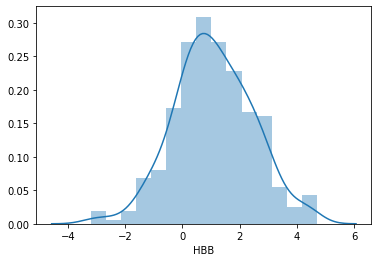

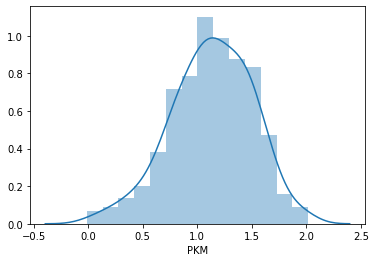

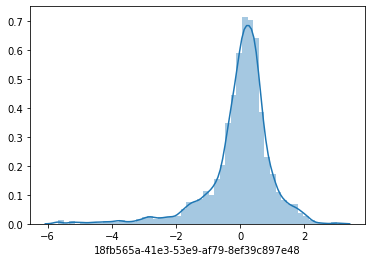

In [12]:
# plot 2 random gene distributions
figure_header("Figure 1","Two sample gene expression distibutions")
sns.distplot(df_data_norm.iloc[0, :]); plt.show()
sns.distplot(df_data_norm.iloc[200, :]); plt.show()

figure_header("Figure 2","Sample individual RNA-Seq profile distribution")
# plot a single RNA seq profile distribution
sns.distplot(df_data_norm.iloc[:, 0]); plt.show()

Now let's visualize expression of the most variable genes across the dataset with hierachical clustering and a heatmap.

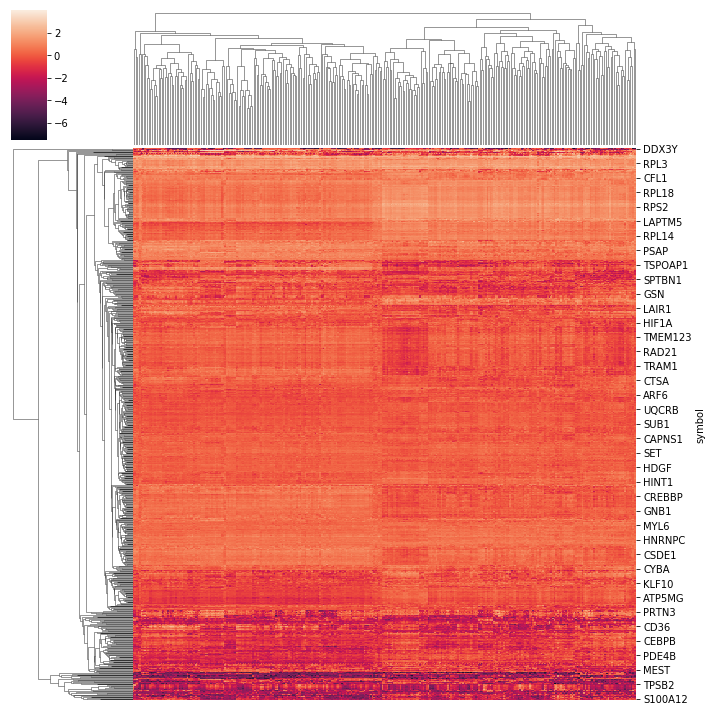

In [13]:
# Normalization
# take top 800 most variable rows

# the "i" in the variable here stands for "initial", since we'll do a different method 
# for selecting genes for a heatmap later
df_data_norm_heatmap_i = filter_by_var(df_data,top_n=800)

# compute log normalization of matrix
df_data_norm_heatmap_i = log2_normalize(df_data_norm_heatmap_i)

# convert to zscores
df_data_norm_heatmap_i = zscore_normalize(df_data_norm_heatmap_i) 

# Plot heatmap
figure_header("Figure 3","Heatmap of normalized expression for top 800 most variable genes")
ax = sns.clustermap(df_data_norm_heatmap_i,xticklabels=False)

We use PCA to initially reduce the dimensionality of the dataset before clustering while still maintaining most of the variability.

In [14]:
# PCA
data_norm_pca = PCA(
  random_state=42,
)

data_norm_pca.fit(df_data_norm.values.T)

df_data_norm_pca = pd.DataFrame(
    data_norm_pca.transform(df_data_norm.values.T),
    index=df_data_norm.T.index
)

df_data_norm_pca.columns = [
    f'PCA-{c}' # ({r:.3f})'
    for c, r in zip(df_data_norm_pca.columns, data_norm_pca.explained_variance_ratio_)
]

df_data_norm_pca.index.name = "case_id"

figure_header("Table 5","Principle components of RNA-Seq data")
display(df_data_norm_pca.head())

PCA-0      PCA-1     PCA-2  \
case_id                                                                
18fb565a-41e3-53e9-af79-8ef39c897e48   3.847205  15.588647 -9.749029   
22020e2c-2e0f-5e82-8f3c-1bfc569af234  21.389736 -19.251862  3.414162   
a5feb1fc-c8b0-53ce-81ab-1f1ff469c0de  10.410051  16.960196  0.015487   
7a9d7f4d-161e-5133-88ce-14d0b2c904fc  11.129028  11.992489  0.682680   
23e96996-f438-4e81-b3b0-d12a0c046fcd  -7.450798 -16.864508  7.749038   

                                         PCA-3     PCA-4     PCA-5     PCA-6  \
case_id                                                                        
18fb565a-41e3-53e9-af79-8ef39c897e48 -3.537323 -6.975798  4.315942 -2.030530   
22020e2c-2e0f-5e82-8f3c-1bfc569af234  8.114356 -0.821147  1.642939 -7.074121   
a5feb1fc-c8b0-53ce-81ab-1f1ff469c0de -2.957669 -0.588679  1.517471 -2.677583   
7a9d7f4d-161e-5133-88ce-14d0b2c904fc  8.969164 -6.730014 -7.082284 -1.127449   
23e96996-f438-4e81-b3b0-d12a0c046fcd -2.899125 -7.933837  1.231095  7.594683   

                                         PCA-7     PCA-8     PCA-9  ...  \
case_id                                                             ...   
18fb565a-41e3-53e9-af79-8ef39c897e48  1.331334  2.028669 -2.502450  ...   
22020e2c-2e0f-5e82-8f3c-1bfc569af234  3.656772  1.443226 -2.891691  ...   
a5feb1fc-c8b0-53ce-81ab-1f1ff469c0de -4.907569 -5.989272 -1.987094  ...   
7a9d7f4d-161e-5133-88ce-14d0b2c904fc  1.628044  6.593376 -4.980771  ...   
23e96996-f438-4e81-b3b0-d12a0c046fcd  4.133619 -2.775221  0.147695  ...   

                                       PCA-297   PCA-298   PCA-299   PCA-300  \
case_id                                                                        
18fb565a-41e3-53e9-af79-8ef39c897e48 -0.100898  0.045468 -0.112367 -0.255081   
22020e2c-2e0f-5e82-8f3c-1bfc569af234 -0.201002  0.174848 -0.044388 -0.215672   
a5feb1fc-c8b0-53ce-81ab-1f1ff469c0de -0.165972  0.060532 -0.005584  0.024425   
7a9d7f4d-161e-5133-88ce-14d0b2c904fc  0.102979 -0.112358 -0.028799  0.043229   
23e96996-f438-4e81-b3b0-d12a0c046fcd  0.232314 -0.466402  0.224811  0.391154   

                                       PCA-301   PCA-302   PCA-303   PCA-304  \
case_id                                                                        
18fb565a-41e3-53e9-af79-8ef39c897e48 -0.022295 -0.005806  0.114841 -0.128507   
22020e2c-2e0f-5e82-8f3c-1bfc569af234  0.360319 -0.004275 -0.053740 -0.006950   
a5feb1fc-c8b0-53ce-81ab-1f1ff469c0de  0.090737 -0.106318  0.029171  0.027499   
7a9d7f4d-161e-5133-88ce-14d0b2c904fc  0.030542  0.033200  0.091571  0.115725   
23e96996-f438-4e81-b3b0-d12a0c046fcd -0.536503  0.034034 -0.043659  0.114966   

                                       PCA-305       PCA-306  
case_id                                                       
18fb565a-41e3-53e9-af79-8ef39c897e48 -0.061787  1.429412e-14  
22020e2c-2e0f-5e82-8f3c-1bfc569af234  0.054243  1.279532e-14  
a5feb1fc-c8b0-53ce-81ab-1f1ff469c0de -0.013865  1.418310e-14  
7a9d7f4d-161e-5133-88ce-14d0b2c904fc  0.034557  1.632028e-14  
23e96996-f438-4e81-b3b0-d12a0c046fcd  0.247656  1.515454e-14  

[5 rows x 307 columns]

In the two plots below (PCA and UMAP projections), datapoints are color-coded by the selected feature. The size of each point represents the number of reads for that sample.

In [15]:
pca_data = merge(
        df_data_norm_pca[["PCA-0", "PCA-1"]],
        df_library_size,
        df_clinical
      )

axes = {
    "x": [min(df_data_norm_pca["PCA-0"])*1.1, max(df_data_norm_pca["PCA-0"])*1.1],
    "y": [min(df_data_norm_pca["PCA-1"])*1.1, max(df_data_norm_pca["PCA-1"])*1.1]
}

figure_header("Figure 4","Projection of RNA-Seq data onto first two principle components")
scatter_plot(pca_data,"PCA-0", "PCA-1",axes,features)

We further reduce the dimensionality of the dataset using the UMAP (Uniform Manifold Approximation and Projection) technique on the data projected onto the first `n_pca_components` PCA components.

In [16]:
# UMAP
data_norm_umap = UMAP(
  random_state=42,
  n_components=2,
  n_neighbors=n_neighbors,
  metric='cosine',
  min_dist=min_cluster_dist,
)

# use top n_pca_components components of PCA
n_pca_components = min(n_pca_components,df_data_norm_pca.shape[1])
data_norm_umap.fit(df_data_norm_pca.iloc[:, :n_pca_components].values)

df_data_norm_umap = pd.DataFrame(
  data_norm_umap.transform(df_data_norm_pca.iloc[:, :n_pca_components].values),
  columns=['UMAP-0', 'UMAP-1'],
  index=df_data_norm_pca.index,
)

In [17]:
# project data onto its first 2 UMAP components for visualization
umap_data = merge(
        df_data_norm_umap[["UMAP-0", "UMAP-1"]],
        df_library_size,
        df_clinical
      )

axes = {
    "x": [min(df_data_norm_umap["UMAP-0"])*1.1, max(df_data_norm_umap["UMAP-0"])*1.1],
    "y": [min(df_data_norm_umap["UMAP-1"])*1.1, max(df_data_norm_umap["UMAP-1"])*1.1]
}

figure_header("Figure 5","Projection of RNA-Seq data onto first two UMAP components")
scatter_plot(umap_data,"UMAP-0", "UMAP-1",axes,features)

We continue using the first 2 UMAP components.

To compute clusters, we use the Kmeans method, which requires us to define a total number of clusters. We test a range for the number of total clusters. 

For each number of clusters, we compute silhouette scores, which are a measure of how similar an entry is to its own cluster compared to other clusters. We want to maximize similarity within a cluster and differrences between clusters, so the ideal number of clusters is that which produces the highest silhouette score.

Here, we modify the selection of $k$ slightly to preserve nuances in the data by preferring more clusters over fewer. We also calcuulated a *modified* silhouette score, which takes into account the number of clusters, $k$; each original score is bumped by a factor linear with respect to $k$. 

In [18]:
def plot_silhouette_analysis(n_clusters, data, cluster_labels, avg_score, sample_values, centers):
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(X[:, 0], X[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                c=colors, edgecolor='k')

    # Draw white circles at cluster centers
    ax2.scatter(centers[:, 0], centers[:, 1], marker='o',
                c="white", alpha=1, s=200, edgecolor='k')

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
                    s=50, edgecolor='k')

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')

In [19]:
silhouette_scores = []

# Set max clusters as a function of the sample size and the user-selected option
max_clusters = math.ceil(df_data_norm_umap.shape[0]**0.5)
if (max_clusters_calculation == "root/2"):
    max_clusters = int(math.ceil(max_clusters/2))

cluster_range = range(2, max_clusters)
for n in cluster_range:
    X = df_data_norm_umap.values
    clusterer = KMeans(n_clusters=n, random_state=42).fit(X)
    y_pred = clusterer.predict(X)
    
    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(X, y_pred, metric='cosine')
    
    # Compute a weighted score that rewards higher numbers of clusters
    weighted_score = silhouette_avg*0.8 + n/max_clusters*0.2
    
    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X, y_pred)

    silhouette_scores.append({
        "N Clusters": n,
        "Silhouette Score": silhouette_avg,
        "Weighted Score": weighted_score
    })
    
    # Labeling the clusters
    centers = clusterer.cluster_centers_
    
    # Plot the analysis for this number of clusters
    #plot_silhouette_analysis(n, X, y_pred, silhouette_avg, sample_silhouette_values, centers)

If using the "second derivative method" for ideal $k$ calculation, we also compute estimates of the second derivatives at each posisble point to see if there are local maxima that may present better values of $k$ than the silhouette scores suggest. If such maxima exist, we take the value of $k$ that presents the most negative approximated second derivative (meaning the plot of scores is most concave *down* at this value of $k$). 

To calculate the second derivatives, we use the following approximation:

$$ f''(x) \approx \frac{f(x+h) - 2f(x) + f(x-h)}{h^2}$$

where, in our case, $h = 1$.

In [20]:
points = {}
threshold = 0.3
for s in silhouette_scores:
    points[s["N Clusters"]] = s["Silhouette Score"]

# No local maxima - resort to previous method of best score calculation
k = None

if (use_second_deriv_method):
    local_maxima = []
    # Collect all local maxima
    for n in range(cluster_range[1], cluster_range[-2]):
        if points[n] > threshold and points[n-1] < points[n] and points[n+1] < points[n]:
            local_maxima.append(n)
    
    if len(local_maxima)>0:
        print("K values for local maxima and positive silhouette score: ", local_maxima)
    else:
        print("No local maxima with positive silhouette scores found")

    # Otherwise, calculate which of the local max is most concave down (i.e. largest second derivative)
    if len(local_maxima) > 0:
        running_max = 0
        for maxima in local_maxima:
            # approximate the second derivative, with step size = 1
            second_deriv = points[maxima + 1] -  2*points[maxima] + points[maxima-1]
            if second_deriv < running_max:
                running_max = second_deriv
                k = maxima

No local maxima with positive silhouette scores found


In [21]:
silhouette_scores = pd.DataFrame(silhouette_scores)
figure_header("Table 6", "Silhouette scores by number of clusters")
display(silhouette_scores.sort_values(["Silhouette Score", "Weighted Score"], ascending=False).reset_index().head())

best_score = silhouette_scores.sort_values('Silhouette Score').iloc[-1].to_dict()
best_weighted = silhouette_scores.sort_values('Weighted Score').iloc[-1].to_dict()

best = {"Silhouette Score": best_score, "Weighted Score": best_weighted}

index  N Clusters  Silhouette Score  Weighted Score
0      2           4          0.113814        0.179940
1      0           2          0.104014        0.127655
2      3           5          0.081085        0.175979
3      1           3          0.022537        0.084696
4      4           6         -0.003621        0.130436

In [22]:
if not k:
    k = int(best["Silhouette Score"]["N Clusters"])
    if (use_weighted_silhouette_score):
        k = int(best["Weighted Score"]["N Clusters"])
    
print(f"Ideal k: {k} clusters")

Ideal k: 4 clusters


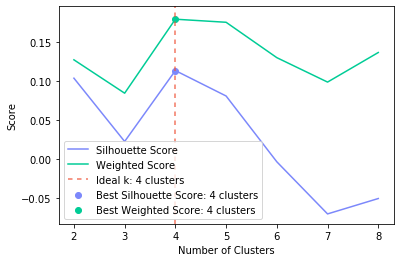

In [23]:
# plot both the uneqeighted and weighted scores as a function of # of clusters
colors = {"Silhouette Score": "#7C88FB", "Weighted Score": "#00CC96"}

for score_type in ['Silhouette Score', 'Weighted Score']:
    plt.plot(silhouette_scores['N Clusters'], silhouette_scores[score_type], label=score_type,color=colors[score_type])
    plt.scatter([best[score_type]['N Clusters']], [best[score_type][score_type]], label=f"Best {score_type}: {int(best[score_type]['N Clusters'])} clusters",color=colors[score_type])
plt.axvline(k, label = f"Ideal k: {k} clusters", color ="#EF553B", alpha=0.8,dashes=(3,3))
plt.legend()
plt.ylabel('Score')
plt.xlabel('Number of Clusters')
figure_header("Figure 6", "Cluster size selection")
plt.show()

In [24]:
# Compute the Kmeans dataframe using the ideal number of clusters
km = KMeans(n_clusters=k, random_state=42)
df_data_norm_km = pd.DataFrame({
'Cluster': [
    str(c)
    for c in km.fit_predict(df_data_norm_umap.values)
]}, index=df_data_norm_umap.index)

print(f'Computed {len(df_data_norm_km["Cluster"].unique())} clusters')

Computed 4 clusters


Next, we compute differential expression for each cluster. We use the <a href="http://www.maayanlab.net/CD/">Characteristic Direction method</a> for identifying differentially expressed genes among the different clusters.

In [25]:
# Get differential expression for each cluster
diff_expr = {}
for cluster, samples in df_data_norm_km.groupby('Cluster'):
    diff_expr[f"Cluster {cluster} CD"] = characteristic_direction(
        # expression outside of this cluster
        df_data_norm.loc[:, df_data_norm.columns.difference(samples.index)],
        # expression in this cluster
        df_data_norm.loc[:, samples.index],
      )['CD-coefficient']

df_diff_expr = pd.DataFrame(diff_expr)
df_diff_expr = df_diff_expr.sort_values(by='Cluster 0 CD',ascending=True)
df_diff_expr['Symbol'] = df_diff_expr.index.values

figure_header("Table 7", "Differential expression of genes by cluster")
display(df_diff_expr.head())

Cluster 0 CD  Cluster 1 CD  Cluster 2 CD  Cluster 3 CD   Symbol
IGF2BP1     -0.118874     -0.042270      0.107647      0.084219  IGF2BP1
RGS2        -0.102684      0.057188     -0.029356      0.084722     RGS2
BTG2        -0.096115      0.063679     -0.026627      0.069289     BTG2
C1QTNF4     -0.094341      0.092985     -0.050862      0.059819  C1QTNF4
IGLL1       -0.092181      0.123316     -0.103021      0.071370    IGLL1

We fit a logistic regression on each clinical feature to see which most accurately predict the cluster each datapoint falls into. We also plot up to 5 ROC curves for features that resulted in an AUC $\gt 0.7$. 

In [26]:
# LR
aucs = {}
num_rocs_plotted = 0
rocs = []

for cluster, samples in df_data_norm_km.groupby('Cluster'): 
    aucs[cluster] = {}

    for feature in features:
        lr = LogisticRegression()
        X = df_clinical.copy()
        X = X[feature]
        X = pd.merge(X, df_data_norm_km, left_index = True, right_index = True)

        # drop NAs, and move on if dataset is empty
        X.replace("not reported", None)
        X = X.dropna()
        if (X.shape[0] == 0): continue

        cluster_data = X["Cluster"]
        X = X.drop(columns= ["Cluster"])

        # one-hot encode non numerical data
        if (not isinstance(X[feature][0], (int, float, complex))):
            X = pd.get_dummies(X[feature], prefix=feature)

        y_true = (cluster_data == cluster)

        if (len(set(y_true)) < 2): continue # if we only have one class in the dataset
        lr.fit(X, y_true)

        y_score = lr.predict_proba(X)[:, 1]
        auc_score = roc_auc_score(y_true, y_score)
        aucs[cluster][feature] = auc_score
        
        # save the ROCs
       
        rocs.append({"auc":auc_score, "lr": lr, "X": X, "y_true":y_true, "title": f'Predictions of cluster {cluster} by feature {feature}'})
        
df_cluster_aucs = pd.DataFrame(aucs)
df_cluster_aucs.index.name="Feature"

figure_header("Table 8", "Average AUC scores for various clinical features, by cluster")
display(df_cluster_aucs.head(10))

0         1         2         3
Feature                                                          
age_at_diagnosis           0.999742  0.999974  0.999971  0.996019
year_of_diagnosis          0.487495  0.563333  0.620805  0.478906
tissue_or_organ_of_origin  0.500000  0.500000  0.500000  0.500000
days_to_birth              0.361906  0.813333  0.909396  0.373434
age_at_index               0.639362  0.813333  0.916107  0.627487
year_of_death              0.457717       NaN  0.585294  0.449894
days_to_death              0.627674  0.722787  0.590410  0.675817
morphology                 0.500000  0.500000  0.500000  0.500000
prior_malignancy           0.518304  0.543333  0.543624  0.515015
race                       0.562006  0.578984  0.553732  0.570544

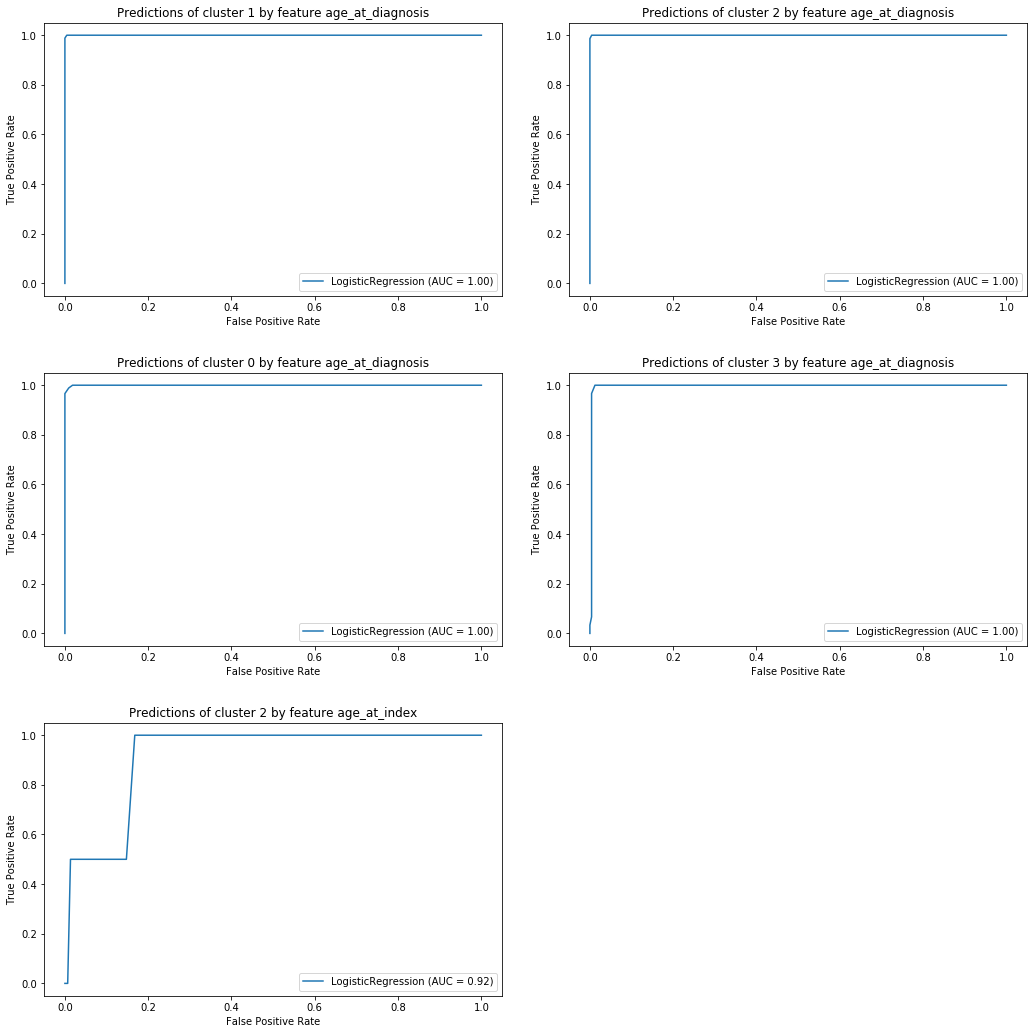

In [27]:
# plot top 5 (or however many exist) ROCs
rocs.sort(reverse=True, key=lambda x: x["auc"])
if len(rocs) < 5:
    best_rocs = rocs
else:
    best_rocs = rocs[0:5]

figure_header("Figure 7", "ROCs for top cluster-predicting clinical features")
num_plots = len(best_rocs)
figure,axes = plt.subplots(int(math.ceil(num_plots / 2.)), 2, figsize=(15,15))

for i in range(len(axes.flatten())):
    if i >= len(best_rocs):
        axes[i // 2, i % 2].remove()
    else:
        plot = best_rocs[i]
        fig = metrics.plot_roc_curve(plot["lr"], plot["X"], plot["y_true"], ax=axes[i // 2, i % 2])
        axes[i // 2, i % 2].set_title(plot["title"])

figure.tight_layout(pad=3)

Next we find the top most up and downregulated genes for each cluster, both to select which data to display in the heatmap below and for Enrichment analysis.

In [28]:
# Merge data
df_clustered_umap = pd.merge(left=df_data_norm_km, left_on="case_id", right=df_data_norm_umap, right_on="case_id")
df_clustered_pca = pd.merge(left=df_data_norm_km, left_on="case_id", right=df_data_norm_pca, right_on="case_id")

In [29]:
# Map each cluster to a color
clusters = df_clustered_umap["Cluster"].unique()
#plotly_colors = px.colors.qualitative.Plotly
plotly_colors = ['#636EFA', '#EF553B', '#00CC96', '#AB63FA', '#FFA15A', '#19D3F3', '#FF6692', '#B6E880', '#FF97FF', '#FECB52']
cluster_colors = {}
i = 0
for c in clusters:
    cluster_colors[c] = plotly_colors[i % len(plotly_colors)]
    i += 1

In [30]:
# Get top Genes for each cluster
top_genes = {}
all_top_genes = []
heatmap_top_n = min(heatmap_top_n, top_n_genes_enrichment)
for cluster in df_clustered_umap['Cluster'].unique():
    cd_col = f'Cluster {cluster} CD'
    if cd_col in df_diff_expr.columns:
        # top up genes
        up_genes = df_diff_expr.loc[df_diff_expr[cd_col].sort_values(ascending=False).iloc[:top_n_genes_enrichment].index, 'Symbol'].values
        # top down genes
        dn_genes = df_diff_expr.loc[df_diff_expr[cd_col].sort_values(ascending=True).iloc[:top_n_genes_enrichment].index, 'Symbol'].values
    else:
        raise Exception('Cant find col for cluster')
    all_top_genes.append(up_genes[:heatmap_top_n])
    all_top_genes.append(dn_genes[:heatmap_top_n])
    # save results
    top_genes[cluster] = (up_genes, dn_genes)
all_top_genes = [item for sublist in all_top_genes for item in sublist]  # flatten all genes to one list

We select data corresponding to only the `heatmap_top_n` up and downregulated genes for each cluster. We log-transform and normalize as before, plotting a heatmap for the results.

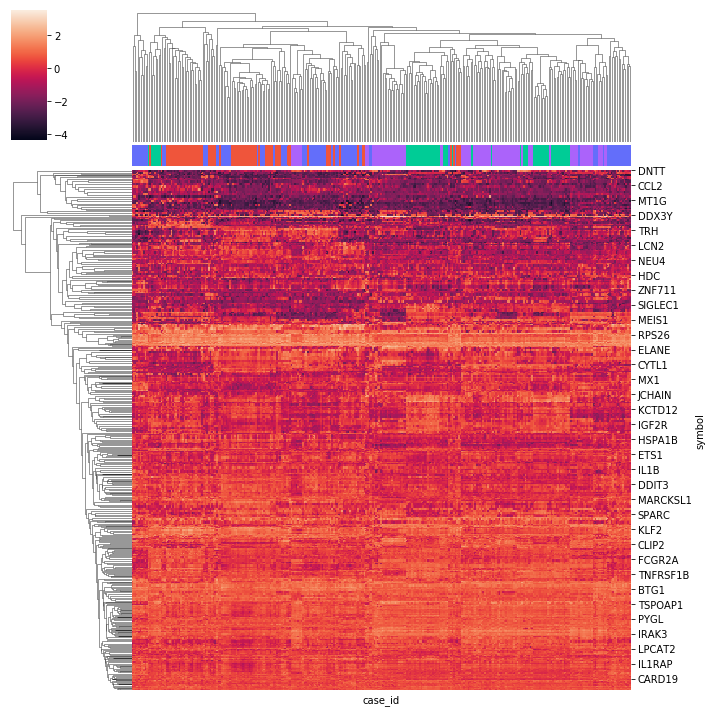

In [31]:
df_data_norm_heatmap_f = df_data.loc[all_top_genes, :]

# compute log normalization of matrix
df_data_norm_heatmap_f = log2_normalize(df_data_norm_heatmap_f)

# convert to zscores
df_data_norm_heatmap_f = zscore_normalize(df_data_norm_heatmap_f) 

# Plot heatmap
cases = df_data_norm_heatmap_f.columns
heatmap_cluster_colors = [ cluster_colors[x] for x in df_clustered_umap.loc[cases, :]["Cluster"] ]

figure_header("Figure 8", "Heatmap of top most differentially expressed genes, with cluster labels")
ax = sns.clustermap(df_data_norm_heatmap_f,xticklabels=False,col_colors = heatmap_cluster_colors)

#  3. Load Enrichr Data  <a class="anchor" id="enrichr"></a>

We query the Enrichr API for enrichment analysis of the top most upregulated and downregulated genes for each cluster calculated above.

In [32]:
# Util functions
def enrichr_link_from_genes(genes, description='', enrichr_link='https://amp.pharm.mssm.edu/Enrichr'):
    ''' Functional access to Enrichr API
    '''
    time.sleep(1)
    resp = requests.post(enrichr_link + '/addList', files={
    'list': (None, '\n'.join(genes)),
    'description': (None, description),
    })
    if resp.status_code != 200:
        raise Exception('Enrichr failed with status {}: {}'.format(
          resp.status_code,
          resp.text,
        ))
    # wait a tinybit before returning link (backoff)
    time.sleep(1)
    result = resp.json()
    return dict(result, link=enrichr_link + '/enrich?dataset=' + resp.json()['shortId'])

def enrichr_get_top_results(userListId, bg, enrichr_link='https://amp.pharm.mssm.edu/Enrichr'):
    time.sleep(1)
    resp = requests.get(enrichr_link + '/enrich?userListId={}&backgroundType={}'.format(userListId, bg))
    if resp.status_code != 200:
        raise Exception('Enrichr failed with status {}: {}'.format(
          resp.status_code,
          resp.text,
        ))
    time.sleep(1)
    return pd.DataFrame(resp.json()[bg], columns=['rank', 'term', 'pvalue', 'zscore', 'combinedscore', 'overlapping_genes', 'adjusted_pvalue', '', ''])

def save_enrichr_data(cancer_type,df_diff_expr,df_clustered_umap,df_all_results,df_cluster_aucs):
    output=f"appyter_data/{cancer_type}"
    os.makedirs(output, exist_ok=True)
    df_diff_expr.to_csv(
        f'{output}/df.tsv',
        sep='\t',
        index=None
    )
    df_clustered_umap.to_csv(
        f'{output}/df_umap.tsv',
        sep='\t',
        index=None
    )
    df_all_results.to_csv(
        f'{output}/df_enrich.tsv',
        sep='\t',
        index=None
    )
    df_cluster_aucs.to_csv(
        f'{output}/cluster_aucs.csv',
        sep='\t',
        index=None
    )

In [33]:
# Get Enrichr links for each cluster
enrichr_links = {}

for cluster, (up_genes, dn_genes) in top_genes.items():
    up_link, dn_link = None, None
    if up_genes.size:
        up_link = enrichr_link_from_genes(up_genes, f'cluster {cluster} up')
    else:
        print(f'cluster {cluster} up: empty')
    if dn_genes.size:
        dn_link = enrichr_link_from_genes(dn_genes, f'cluster {cluster} down')
    else:
        print(f'cluster {cluster} down: empty')
    enrichr_links[cluster] = (up_link, dn_link)

# Grab top results for each cluster
all_enrichr_results = []
for cluster, (up_link, dn_link) in enrichr_links.items():
    for link_type, link in [('up', up_link), ('down', dn_link)]:
        if link is None:
            continue
        for category, libraries in enrichr_libraries.items():
            for library in libraries:
                try:
                    results = enrichr_get_top_results(link['userListId'], library).sort_values('pvalue').iloc[:top_n_results]
                    results['link'] = link['link']
                    results['library'] = library
                    results['category'] = category
                    results['direction'] = link_type
                    results['cluster'] = cluster
                    all_enrichr_results.append(results)
                except:
                    print('{}: {} {} {} cluster {} failed, continuing'.format(link, library, category, link_type, cluster))

df_enrichr_results = pd.concat(all_enrichr_results).reset_index()

In [34]:
# Display a dataframe with clickable enrichr links
figure_header("Table 9", "Enrichment analysis results from Enrichr")
df_clickable = df_enrichr_results.copy()
df_clickable['link'] = df_clickable["link"].apply(make_clickable)
table_html = df_clickable.to_html(escape=False)
display(HTML(f'<div style="max-height: 250px; overflow-y: auto; margin-bottom: 25px;">{table_html}</div>'))
download_button(df_enrichr_results.to_csv(), 'Download Enrichr results', 'Enrichr results.csv')

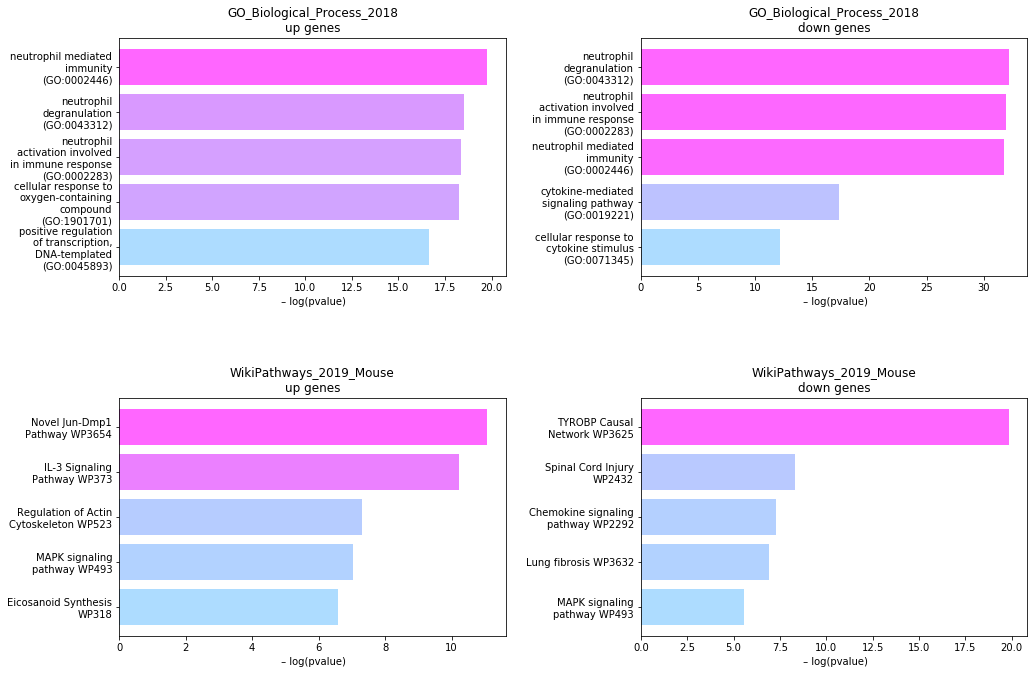

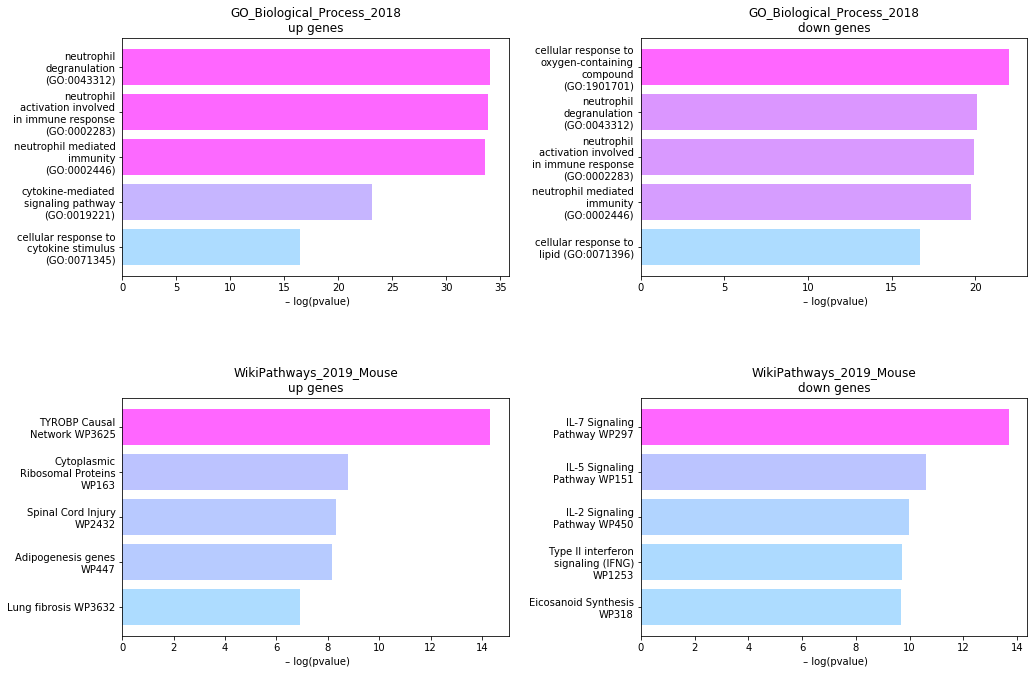

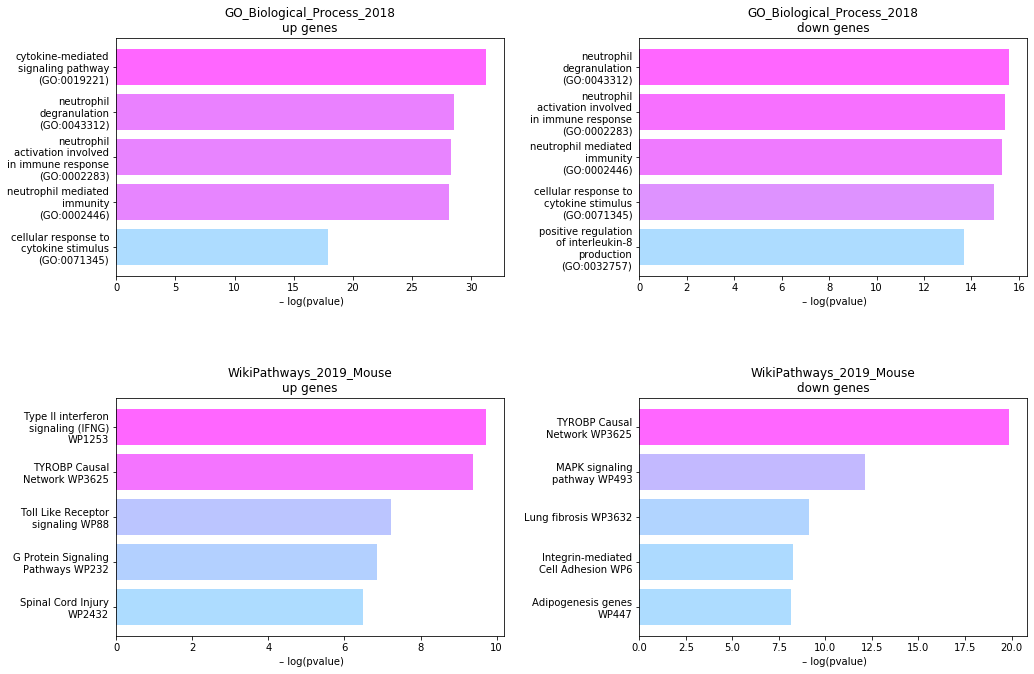

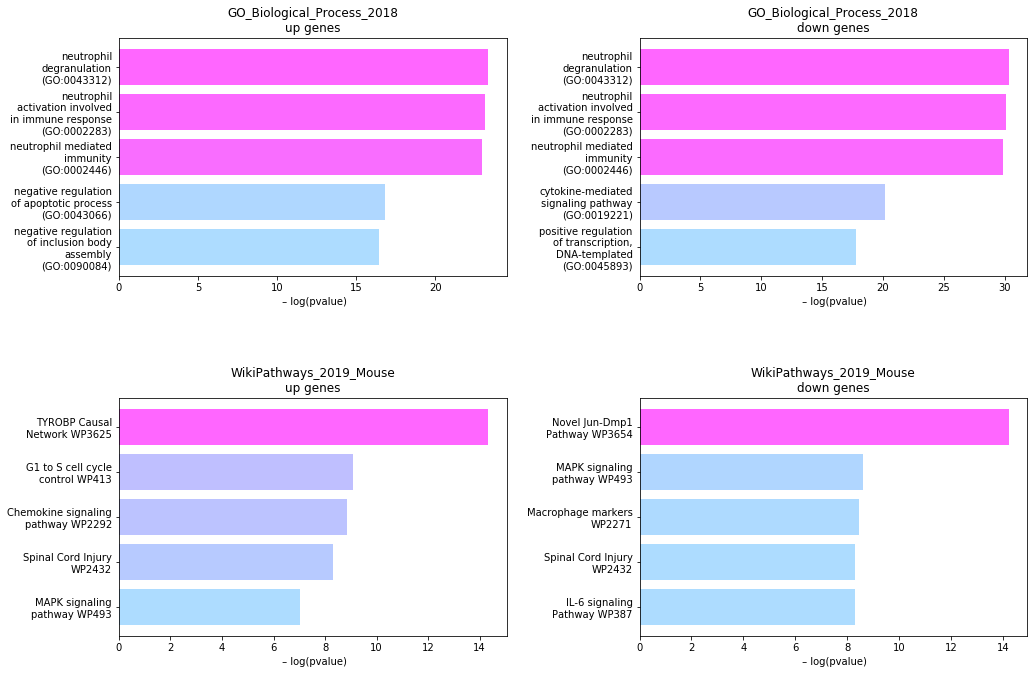

In [35]:
figure_header("Figure 9", "Projection of data onto first two UMAP components, with clusters color-coded")
fig = px.scatter(
    df_clustered_umap,
    x = df_clustered_umap['UMAP-0'],
    y = df_clustered_umap['UMAP-1'],
    color = "Cluster",
)

fig.update_traces(marker=dict(
            size=12,
            opacity=0.8,
            line=dict(
                color='white',
                width=1
            )))
fig.show()

def cluster_heading(cluster):
    display(HTML(f'''
    <center>
    <div style='background-color:{cluster_colors[cluster] + '98'};
        width:15in;max-width:100%;height:3rem;display:flex;align-items:center;
        justify-content:center;color:white;font-size:2rem'>
        <center>Cluster {cluster}</center>
    </div>
    </center>'''))
    
figure_header("Figure 10", "Enichment results, by cluster")

# Make horizontal barplots to visualize top Enrichr results
clusters = df_enrichr_results["cluster"].unique()
for cluster in clusters:
    cluster_results = df_enrichr_results.loc[df_enrichr_results["cluster"] == cluster, :]
    libraries = cluster_results["library"].unique()
    num_rows = len(libraries)

    count = 1 # keep track of which subplot we're on
    fig = plt.figure(figsize=(15,5*num_rows))
    
    for library in cluster_results["library"].unique():
            library_results = cluster_results.loc[cluster_results["library"] == library, :]
            for direction in library_results["direction"].unique():
                plot_results = library_results.loc[cluster_results["direction"] == direction, :]
                plot_results = plot_results.sort_values("pvalue",ascending=False)
                labels = plot_results["term"]
                labels = [ '\n'.join(wrap(l, 20)) for l in labels ]
                values = plot_results["pvalue"]
                values = -np.log(values)
                
                # normalize values to map from 0-1 -> color, with opacity also based on normalized pvalue
                cmap = plt.get_cmap('cool')
                norm_values = [ 0.3 + (x - min(values))/(max(values) - min(values))*0.7 for x in values]
                colors = [ [*cmap(val)[:3], 0.4  + 0.2*val] for val in norm_values]
                
                # plot result
                ax = fig.add_subplot(num_rows,2,count)
                ax.barh(labels,values,color = colors)
                ax.set_title(f'{library}\n{direction} genes')
                ax.set_xlabel(' – log(pvalue)')
                count += 1
                
    cluster_heading(cluster)
    #title = plt.suptitle(f'Cluster {cluster}',fontsize=24, color="white",bbox=(dict(facecolor=cluster_colors[cluster], alpha=0.8,pad=5)))
    fig.tight_layout(pad=3, w_pad=2, h_pad=6)
    plt.show()
    display(HTML("<br><br>"))

# 4. Load L1000 Data  <a class="anchor" id="l1000"></a>

We query the <a href="https://amp.pharm.mssm.edu/L1000FWD/" target="_blank">L1000 Fireworks Display</a> (L1000FWD) API to find the most similar and most dissimilar RNA-seq signatures from the L1000 database for each cluster based on the up and down genes. We also link to the L1000FWD interactive projection of those results for each cluster.

In [36]:
# Util functions
def l1000fwd_results_from_genes(up_genes, down_genes, description='', l100fwd_link='http://amp.pharm.mssm.edu/L1000FWD/'):
    ''' Functional access to L1000FWD API
    '''
    import time
    time.sleep(1)
    response = requests.post(l100fwd_link + 'sig_search', json={
    'up_genes': list(up_genes),
    'down_genes': list(down_genes),
    })
    l1000fwd_results =  {}
    if response.status_code != 200:
        raise Exception('L1000FWD failed with status {}: {}'.format(
          response.status_code,
          response.text,
        ))
    if 'KeyError' in response.text:
        l1000fwd_results['result_url'] = None
    else:
        # Get ID and URL
        result_id = response.json()['result_id']
        l1000fwd_results['result_url'] = 'https://amp.pharm.mssm.edu/l1000fwd/vanilla/result/'+result_id
        l1000fwd_results['result_id'] = result_id

        # Get Top
        l1000fwd_results['signatures'] = requests.get(l100fwd_link + 'result/topn/' + result_id).json()

    # wait a tinybit before returning link (backoff)
    time.sleep(1)
    return l1000fwd_results

def l1000fwd_sig_link(sig_id):
    return 'https://amp.pharm.mssm.edu/dmoa/sig/' + sig_id

def get_signature_by_id(sig_id):
    response = requests.get("http://amp.pharm.mssm.edu/L1000FWD/sig/" + sig_id)
    if response.status_code != 200:
        raise Exception('L1000FWD signature query  failed with status {}: {}'.format(
          response.status_code,
          response.text,
        ))
    return response.json()

In [37]:
def display_l1000fwd_results(l1000fwd_results, plot_counter,cluster_id,nr_drugs=7, height=300):
    # Check if results
    if l1000fwd_results['result_url']:

        # Display cluster title
        display(HTML('<br><br>'))
        cluster_heading(cluster)

        # Display IFrae
        display(HTML(f"<a href='{l1000fwd_results['result_url']}' target='_blank'> View L1000FWD for cluster {cluster_id}</a>"))
    
        # Display tables
        for direction, signature_list in l1000fwd_results['signatures'].items():

            # Fix dataframe
            rename_dict = {'sig_id': 'Signature ID', 'pvals': 'P-value', 'qvals': 'FDR', 'zscores': 'Z-score', 'combined_scores': 'Combined Score'}
            signature_dataframe = pd.DataFrame(signature_list)[list(rename_dict.keys())].rename(columns=rename_dict).sort_values('P-value').rename_axis('Rank')
            signature_dataframe.index = [x + 1 for x in range(len(signature_dataframe.index))]
            signature_csv = signature_dataframe.to_csv(sep=",")

            # Display table
            pd.set_option('max.colwidth', None)
            signature_dataframe['Signature ID'] = [f'<a href={l1000fwd_sig_link(x)} target="_blank">{x}</a>' for x in signature_dataframe['Signature ID']]
            table_html = signature_dataframe.to_html(escape=False, classes='w-100')
            display(HTML(f'<h3>{direction.title()} Signatures: </h3>'))
            display(HTML(f'<style>.w-100{{width: 100% !important;}}</style><div style="max-height: 250px; overflow-y: auto; margin-bottom: 25px;">{table_html}</div>'))

            # Display download button
            download_button(signature_csv, f'Download {direction.title()} Signatures', f'Cluster {cluster_id} L1000FWD {direction.title()} signatures.csv')
        # Link
        display(HTML('Full results available at: <a href="{result_url}" target="_blank">{result_url}</a>.'.format(**l1000fwd_results)))
        
    # Display error
    else:
        display(Markdown('### No results were found.\n This is likely due to the fact that the gene identifiers were not recognized by L1000FWD. Please note that L1000FWD currently only supports HGNC gene symbols (https://www.genenames.org/). If your dataset uses other gene identifier systems, such as Ensembl IDs or Entrez IDs, consider converting them to HGNC. Automated gene identifier conversion is currently under development.'))


In [38]:
plot_counter = 0
all_l1000fwd_results = {}
figure_header("Figure 11", "Most similar and opposite L1000 signatures, by cluster")
for cluster, (up_genes, dn_genes) in top_genes.items():
    results = l1000fwd_results_from_genes(up_genes,dn_genes)
    all_l1000fwd_results[cluster] = results
    display_l1000fwd_results(results,plot_counter,cluster)
    plot_counter += 1

Based on the signatures most "opposite" to the profile of a given cluster (i.e. up and down genes are reversed), we can obtain a set of drugs that may "perturb" that cluster into the healthy direction by upregulating its downregulated genes and downregulating the upregulated genes. These may present effective treatments for patients belonging to that cluster.

In [39]:
df_drugs = pd.read_csv("https://amp.pharm.mssm.edu/l1000fwd/download/Drugs_metadata.csv")

# Load top drug suggestions for each cluster based on the drugs used to produce the top_n_drugs opposite signatures
drug_results = {}
for cluster, results in all_l1000fwd_results.items():
    opposite_sigs = results["signatures"]["opposite"][:top_n_drugs]
    sig_ids = [sig["sig_id"] for sig in opposite_sigs]
    pert_ids = []
    for sig_id in sig_ids:
        signature = get_signature_by_id(sig_id)
        pert_ids.append(signature["pert_id"])
    
    df_cluster_drugs = df_drugs[df_drugs["pert_id"].isin(pert_ids)].copy()
    df_cluster_drugs["cluster"] = cluster
    df_cluster_drugs = df_cluster_drugs[["cluster", *list(filter(lambda x: x!="cluster", df_cluster_drugs.columns))]]
    drug_results[cluster] = df_cluster_drugs
    
df_all_drugs = pd.concat(drug_results).reset_index()

In [40]:
# Display a dataframe with clickable L1000FWD links
figure_header("Table 10", "Drugs used to produce most opposite signatures for each cluster")
df_clickable = df_all_drugs.copy()
df_clickable['pert_url'] = df_clickable["pert_url"].apply(make_clickable)
table_html = df_clickable.to_html(escape=False)
display(HTML(f'<div style="max-height: 250px; overflow-y: auto; margin-bottom: 25px;">{table_html}</div>'))
download_button(df_all_drugs.to_csv(), 'Download L1000FWD drug results', 'L1000FWD drugs.csv')

In [3]:
data_filename = ''''''''
clinical_data_filename = ''''''''
cancer = '''Acute myeloid leukemia, NOS'''
n_pca_components = 10
n_neighbors = 40
min_cluster_dist = 0.3
top_n_genes = 2500
max_clusters_calculation = 'root/2'
use_weighted_silhouette_score = True
use_second_deriv_method = True
top_n_genes_enrichment = 250
heatmap_top_n = 100
top_n_results = 5
use_default_libraries = False
transcription_libraries = []
pathways_libraries = ['WikiPathways_2019_Mouse']
ontologies_libraries = ['GO_Biological_Process_2018']
diseases_drugs_libraries = []
cell_types_libraries = []
miscellaneous_libraries = []
legacy_libraries = []
crowd_libraries = []
top_n_drugs = 5
default_libraries = OrderedDict([
    ('Diseases/Drugs', ['GWAS_Catalog_2019']), 
    ('Ontologies', ['GO_Biological_Process_2018','MGI_Mammalian_Phenotype_Level_4_2019']),
    ('Pathways', ['KEGG_2019_Human','KEGG_2019_Mouse']),
    ('Transcription', ['ENCODE_TF_ChIP-seq_2015']),
])
if use_default_libraries:
    enrichr_libraries = default_libraries
else: 
    enrichr_libraries = OrderedDict([
        ('Diseases/Drugs', diseases_drugs_libraries), 
        ('Ontologies', ontologies_libraries),
        ('Cell Type', cell_types_libraries),
        ('Pathways', pathways_libraries),
        ('Transcription', transcription_libraries),
        ('Legacy', legacy_libraries),
        ('Crowd', crowd_libraries)
    ])
    all_empty = True
    for key,libs in enrichr_libraries.items():
        if len(libs) > 0:
            all_empty = False
            break
    if all_empty:
        enrichr_libraries = default_libraries

In [ ]:
cancers=["Infiltrating duct carcinoma, NOS",
         "Squamous cell carcinoma, NOS",
         "Lobular carcinoma, NOS",
         "Acute myeloid leukemia, NOS",
         "Hepatocellular carcinoma, NOS",
         "Serous cystadenocarcinoma, NOS",
         "Endometrioid adenocarcinoma, NOS",
         "Adenocarcinoma, NOS",
         "Clear cell adenocarcinoma, NOS",
         "Glioblastoma","Mucinous adenocarcinoma",
         "Transitional cell carcinoma",
         "Malignant melanoma, NOS",
         "Papillary adenocarcinoma, NOS"]
#cancer = cancers[5]
print(cancer)

1. [Import dataset](#import)